This notebook, which is my submission for WinHacks 2021, will detail the training of the Pyra Deep Learning Bot.

TLDR Implementation Details:
- ResNet200D, to Encode Images, leveraged Transfer Learning
- MultiClass Classification Problem

# Load Dependencies and the Dataset(Recipes-5k)

In [1]:
%%capture 
# Various Dependencies from pytorch 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

# Other handy imports
import numpy as np
import pandas as pd
import copy
import math
import random
!pip install livelossplot
import livelossplot
!pip install timm
import timm
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

import albumentations as A
from albumentations.pytorch import ToTensorV2
import tqdm.notebook as tqdm
import cv2
import PIL
import re
# Set up GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Reproducibility:

In [2]:
import os
import random
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

# Process Dataset

In [4]:
%%capture
!conda install -y gdown
!gdown https://drive.google.com/uc?id=11ojDNqjowZIf9RzLWc25_xnoHefDvSBS
!unzip ./Recipes5k.zip
!rm -f ./Recipes5k.zip

In [5]:
# HYPER PARAMETERS
base_path = './Recipes5k/images/'
train_path = "./Recipes5k/annotations/train_images.txt"
val_path = "./Recipes5k/annotations/val_images.txt"
test_path = "./Recipes5k/annotations/test_images.txt"
train_labels = './Recipes5k/annotations/train_labels.txt'
val_labels = './Recipes5k/annotations/val_labels.txt'
test_labels = './Recipes5k/annotations/test_labels.txt'
ground_truth_labels = "./Recipes5k/annotations/ingredients_simplified_Recipes5k.txt"

In [6]:
def process_line(line):
    page= str.strip(line)
    idx = 0
    for i in range(len(page)):
        if page[i] == '/':
            idx = i
            break
    return page, page[:idx]
def load_all():
    TRAIN_IMAGES = []
    TRAIN_CLASSES = []
    TRAIN_GTS = []
    GROUND_TRUTHS = []
    UNIQUE_INGREDIENTS = []
    # Load in All Images
    with open(train_path, "r") as file:
        for line in file:
            page, class_val = process_line(line)
            TRAIN_IMAGES += [page]
            TRAIN_CLASSES += [class_val]
                
    with open(val_path, "r") as file:
        for line in file:
            page, class_val = process_line(line)
            TRAIN_IMAGES += [page]
            TRAIN_CLASSES += [class_val]
    with open(test_path, 'r') as file:
        for line in file:
            page, class_val = process_line(line)
            TRAIN_IMAGES += [page]
            TRAIN_CLASSES += [class_val]
    # Load in Ground Truth Ingredients
    with open(ground_truth_labels, "r") as file:
        for line in file:
            vals = str.lower(str.strip(line)).split(',')
            GROUND_TRUTHS += [vals]
            UNIQUE_INGREDIENTS += vals
    UNIQUE_INGREDIENTS = sorted(list(set(UNIQUE_INGREDIENTS)))
    # Load in True Values
    with open(train_labels, 'r') as file:
        for line in file:
            val = int(str.strip(line))
            TRAIN_GTS +=[GROUND_TRUTHS[val]]
    with open(val_labels, "r") as file:
        for line in file:
            val = int(str.strip(line))
            TRAIN_GTS += [GROUND_TRUTHS[val]]
    with open(test_labels, "r") as file:
        for line in file:
            val = int(str.strip(line))
            TRAIN_GTS += [GROUND_TRUTHS[val]]
    return TRAIN_IMAGES, TRAIN_CLASSES, sorted(list(set(TRAIN_CLASSES))), TRAIN_GTS, UNIQUE_INGREDIENTS

In [7]:
Train_Images, Train_Classes, Unique_Classes, Train_GT, Unique_Ingredients = load_all()

Training Transforms

In [8]:
# Hyper Parameters Set
IMAGE_SIZE = 224
BATCH_SIZE = 64
TEST_BATCH_SIZE = 128

In [9]:
train_transforms = A.Compose([
    A.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE, scale=(0.6, 0.6), p=1),
    A.Flip(p = 0.7),
    A.OneOf([
        A.MotionBlur(blur_limit=(3, 5)),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=(3, 5)),
        A.GaussNoise(var_limit=(5.0, 30.0)),
        A.MultiplicativeNoise(),
    ], p=0.7),
    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=0.7),
    A.CLAHE(clip_limit=4.0, p=0.7),
    A.IAASharpen(p=0.5),
    A.ColorJitter(p = 0.7),
    A.OneOf([
        A.ImageCompression(),
        A.Downscale(scale_min=0.7, scale_max=0.95),
    ], p=0.2),
    A.OneOf([
        A.ToGray(),
        A.ToSepia()
    ]),
    A.CoarseDropout(max_holes=8, max_height=int(IMAGE_SIZE * 0.1),
                       max_width=int(IMAGE_SIZE* 0.1), p=0.5),
    A.Cutout(num_holes = 32),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=45, border_mode=0, p=0.85),
    A.Normalize(mean=0.482288, std=0.22085),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(),
    ToTensorV2()
])

Custom Dataset

In [10]:
class RecipesDataset(torch.utils.data.Dataset):
    def __init__(self, images, GT, GT_classes, unique_classes, unique_ingredients, transforms, device):
        self.base_path = base_path # Defined In Hyper Parameter
        self.images = images
        self.device = device
        self.GT = GT
        self.transforms = transforms
        self.unique_ingredients = unique_ingredients
        self.unique_classes = unique_classes
        self.GT_classes = GT_classes
        self.num_ingredients = len(self.unique_ingredients)
        # Create Dictionary Mapping ingredients to keys
        self.ingredient2idx = {}
        self.idx2ingredient = {}
        for idx in range(len(self.unique_ingredients)):
            self.ingredient2idx[self.unique_ingredients[idx]] = idx
            self.idx2ingredient[idx] = self.unique_ingredients[idx]
        # Dictionary Mapping Classes to Keys
        self.class2idx = {}
        self.idx2class = {}
        for idx in range(len(self.unique_classes)):
            self.class2idx[self.unique_classes[idx]] = idx
            self.idx2class[idx] = self.unique_classes[idx]
    def decode_Ing_Prediction(self, predictions):
        '''
        Decodes Predictions into a list of ingredients.
        predictions: Tensor(B, L)
        '''
        B, L = predictions.shape
        batched_ingredients = []
        for b in range(B):
            ingredients = []
            for l in range(L):
                if predictions[b, l]:
                    ingredients += [self.idx2ingredient[l]]
            batched_ingredients += [ingredients]
        return batched_ingredients
        
    def decode_Class_Prediction(self, predictions):
        '''
        Decodes Class Predictions into list of class prediction 
        predictions: Tensor(C)
        '''
        C = predictions.shape[0]
        classes_pred = []
        for val_idx in range(C):
            classes_pred += [self.class2idx[predictions[val_idx].item()]]
        return classes_pred
        
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image_path = self.base_path + self.images[idx]
        GT = self.GT[idx]
        GT_class = self.class2idx[self.GT_classes[idx]]
        # Create GT Tensor(sparse one-hot)
        ground_truth = torch.zeros((self.num_ingredients), device = self.device)
        # Encode each ingredient
        for ingredient in GT:
            ground_truth[self.ingredient2idx[ingredient]] = 1
        # Load in Image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Augment Image
        image = self.transforms(image = image)['image']
        return image, ground_truth, GT_class

In [11]:
splitter = ShuffleSplit(1, test_size = 0.015, train_size = 0.985, random_state = 42)
for train_idx, test_idx in splitter.split(Train_Images):
    break

In [12]:
train_split_Images = [Train_Images[idx] for idx in train_idx.tolist()]
train_split_GT = [Train_GT[idx] for idx in train_idx.tolist()]
train_split_classes = [Train_Classes[idx] for idx in train_idx.tolist()]

val_split_Images = [Train_Images[idx] for idx in test_idx.tolist()]
val_split_GT = [Train_GT[idx] for idx in test_idx.tolist()]
val_split_classes = [Train_Classes[idx] for idx in test_idx.tolist()]

In [13]:
Train_Dataset = RecipesDataset(train_split_Images, train_split_GT, train_split_classes, Unique_Classes, Unique_Ingredients, train_transforms, device)
Val_Dataset = RecipesDataset(val_split_Images, val_split_GT, val_split_classes, Unique_Classes, Unique_Ingredients, test_transforms, device)

In [14]:
# Create DataLoaders
Train_Dataloader = torch.utils.data.DataLoader(Train_Dataset, batch_size = BATCH_SIZE, shuffle = True, worker_init_fn = seed_worker)
Val_Dataloader= torch.utils.data.DataLoader(Val_Dataset, batch_size = TEST_BATCH_SIZE, shuffle = False, worker_init_fn = seed_worker)

# Handy CNN Blocks

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_features, out_features, kernel_size, padding, groups):
        super().__init__()
        self.conv = nn.Conv2d(in_features, out_features, kernel_size = kernel_size, padding = padding, groups = groups)
        self.bn = nn.BatchNorm2d(out_features)
        self.act1 = nn.SiLU(inplace = True)
    def forward(self, x):
        return self.bn(self.act1(self.conv(x)))

In [16]:
class SqueezeExcite(nn.Module):
    def __init__(self, in_channels, inner_channels):
        super().__init__()
        self.in_channels = in_channels
        self.inner_channels = inner_channels
        self.Squeeze = nn.Linear(self.in_channels, self.inner_channels)
        self.act1 = nn.SiLU(inplace = True)
        self.Excite = nn.Linear(self.inner_channels, self.in_channels)
    def forward(self, x):
        avg_pool = torch.mean(x, dim = -1)
        avg_pool = torch.mean(avg_pool, dim = -1)
        squeezed = self.act1(self.Squeeze(avg_pool))
        excited = torch.sigmoid(self.Excite(squeezed)).unsqueeze(-1).unsqueeze(-1)
        return excited * x

In [17]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, inner_channels, device):
        super().__init__()
        self.device = device 
        self.in_channels = in_channels
        self.inner_channels = inner_channels
        
        self.Squeeze = ConvBlock(self.in_channels, self.inner_channels, 1, 0, 1)
        self.Process = ConvBlock(self.inner_channels, self.inner_channels, 3, 1, 1)
        self.Expand = ConvBlock(self.inner_channels, self.in_channels, 1, 0, 1)
        self.SE = SqueezeExcite(self.in_channels, self.in_channels // 16)
        self.gamma = nn.Parameter(torch.zeros((1), device = self.device))
    def forward(self, x):
        squeezed = self.Squeeze(x) 
        processed = self.Process(squeezed)
        expanded = self.Expand(processed)
        excited = self.SE(expanded)
        return self.gamma * excited + x

In [18]:
class InverseResidualBlock(nn.Module):
    def __init__(self, in_channels, inner_channels, device):
        super().__init__()
        self.in_channels = in_channels
        self.inner_channels = inner_channels 
        self.device = device
        
        self.expand = ConvBlock(self.in_channels, self.inner_channels, 1, 0, 1)
        self.depthwise = ConvBlock(self.inner_channels, self.inner_channels, 3, 1, self.inner_channels)
        self.SE = SqueezeExcite(self.inner_channels, self.inner_channels // 16)
        self.squeeze = ConvBlock(self.inner_channels, self.in_channels, 1, 0, 1)
        self.gamma = torch.zeros((1), device = self.device)
    def forward(self, x):
        expand = self.expand(x)
        depthwise = self.depthwise(expand)
        excited = self.SE(depthwise)
        squeezed = self.squeeze(excited)
        return self.gamma * squeezed + x



# Model Part 1: ResNet200D(+ ModifiedParts)

In [19]:
class ModifiedResNetQT(nn.Module):
    def freeze(self, x):
        for parameter in x.parameters():
            parameter.requires_grad = False
    def unfreeze(self, x):
        for parameter in x.parameters():
            parameter.requires_grad = True
    def __init__(self, in_dim, device, drop_prob = 0.1):
        super().__init__()
        self.in_dim = in_dim
        self.drop_prob = drop_prob
        self.device = device
        
        self.model_name = "resnet200d"
        self.model = timm.create_model(self.model_name, pretrained = True)
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.freeze(self.model)
        # Extract Layers
        self.conv1 = self.model.conv1
        self.bn1 = self.model.bn1
        self.act1 = self.model.act1
        self.pool = self.model.maxpool
        
        self.layer1 = self.model.layer1
        self.layer2 = self.model.layer2
        self.layer3 = self.model.layer3
        self.layer4 = self.model.layer4
        #self.unfreeze(self.layer3)
        self.unfreeze(self.layer4)
        
        
        self.Attention1 = nn.Identity()#SqueezeExcite(1024, 128)
        self.Attention2 = SqueezeExcite(2048, 256)
        self.Attention3 = SqueezeExcite(2048, 256)
        self.features_extract = nn.Sequential(*[
            BottleNeck(2048, 512, self.device) for i in range(7)
        ])
        self.proj = ConvBlock(2048, self.in_dim, 1, 0, 1)
        self.dropout = nn.Dropout2d(self.drop_prob)
        
    def forward(self, x):
        features0 = self.pool(self.bn1(self.act1(self.conv1(x))))
        layer1 = self.layer1(features0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        # Attention1
        layer3 = self.Attention1(layer3)
        layer4 = self.layer4(layer3)
        # Attention2
        layer4 = self.Attention2(layer4)
        # Dropout
        layer4 = self.dropout(layer4)
        # Additional Processing
        features = self.features_extract(layer4)
        features = self.Attention3(features)
        features = self.proj(features)
        return features
        

In [20]:
class FeatureExtractor(nn.Module):
    def __init__(self, out_dim, device):
        super().__init__()
        self.out_dim = out_dim
        self.device = device
        self.ResNet = ModifiedResNetQT(self.out_dim, self.device)
    def forward(self, images):
        features = self.ResNet(images)
        return features # (B, 384, 7, 7)

In [21]:
class Pyra_Class(nn.Module):
    def __init__(self, num_classes, device, drop_prob = 0.2):
        # File_path: the path to the pretrained feature extractor
        # Im_size: the size of the image after encoding(7x7 = 49), allows us to precompute positional encodings
        super().__init__()
        self.device = device
        self.drop_prob = drop_prob 
        self.in_dim = 4096
        self.num_classes = num_classes
        self.Class_Encoder = FeatureExtractor(self.in_dim, self.device)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.Dropout = nn.Dropout(self.drop_prob)
        self.ClassLinear = nn.Linear(self.in_dim, self.num_classes) # Class Classification Head
    def save(self):
        torch.save(self.state_dict(), "./Class.pth")
    def forward(self, x):
        encoded_class = self.Class_Encoder(x)
        processed_class = torch.squeeze(self.avg_pool(encoded_class))
        if len(processed_class.shape) == 1:
            processed_class = processed_class.unsqueeze(0)
        processed_class = self.Dropout(processed_class)
        Class = self.ClassLinear(processed_class)
        return Class

In [22]:
class Pyra_Ing(nn.Module):
    def __init__(self, num_ing_classes, device, drop_prob = 0.2):
        # File_path: the path to the pretrained feature extractor
        # Im_size: the size of the image after encoding(7x7 = 49), allows us to precompute positional encodings
        super().__init__()
        self.device = device
        self.drop_prob = drop_prob 
        self.in_dim = 4096
        self.num_ing_classes = num_ing_classes
        self.Ing_Encoder = FeatureExtractor(self.in_dim, self.device)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.Dropout = nn.Dropout(self.drop_prob)
        self.IngLinear = nn.Linear(self.in_dim, self.num_ing_classes) # Ingredient Classification Head
    def save(self):
        torch.save(self.state_dict(), "./Ingredient.pth")
    def forward(self, x):
        encoded_ing = self.Ing_Encoder(x)
        processed_ing = torch.squeeze(self.avg_pool(encoded_ing))
        if len(processed_ing.shape) == 1:
            processed_ing = processed_ing.unsqueeze(0)
        processed_ing = self.Dropout(processed_ing)
        IngClass= self.IngLinear(processed_ing)
        return IngClass

In [25]:
class Pyra(nn.Module):
    def __init__(self, num_ing_classes, num_classes, device, drop_prob = 0.2):
        # File_path: the path to the pretrained feature extractor
        # Im_size: the size of the image after encoding(7x7 = 49), allows us to precompute positional encodings
        super().__init__()
        self.device = device
        self.drop_prob = drop_prob 
        self.num_classes = num_classes
        self.num_ing_classes = num_ing_classes
        self.PyraClass = Pyra_Class(self.num_classes, self.device, drop_prob = self.drop_prob)
        self.PyraIng = Pyra_Ing(self.num_ing_classes, self.device, drop_prob = self.drop_prob)
    def load_ing(self, path):
        self.PyraIng.load_state_dict(torch.load(path, map_location = self.device))
    def load_class(self, path):
        self.PyraClass.load_state_dict(torch.load(path, map_location = self.device))
    def save_ing(self):
        self.PyraIng.save()
    def save_class(self):
        self.PyraClass.save()
    def forward_ing(self, x):
        return self.PyraIng(x) 
    def forward_class(self, x):
        return self.PyraClass(x)
    def forward(self, x):
        return self.PyraIng(x), self.PyraClass(x)

# Step 3: Training

In [26]:
class PyraSolver(nn.Module):
    def __init__(self, num_ing_classes, num_classes, device):
        super().__init__()
        self.device = device
        self.num_ing_classes = num_ing_classes
        self.num_classes = num_classes
        self.Pyra = Pyra(self.num_ing_classes, self.num_classes, self.device)
        self.optim = optim.Adam(self.Pyra.parameters(), lr = 1e-5, weight_decay = 1e-3)
        self.lr_decay = optim.lr_scheduler.CosineAnnealingLR(self.optim, 5, eta_min = 1e-8)
        self.IngCriterion = nn.BCEWithLogitsLoss()
        self.ClassCriterion = nn.CrossEntropyLoss()
    def forward(self, images):
        '''
        Test Time Inference on the Model
        '''
        self.eval()
        with torch.no_grad():
            IngPred, ClassPred= self.Pyra(images)
            IngPred = torch.sigmoid(IngPred)
            ClassPred = F.softmax(ClassPred)
            selected_ingredients = IngPred >= 0.5
            _, selected_classes = torch.max(ClassPred, dim = -1)
            return selected_ingredients, selected_classes
    def evaluate_class(self, classes, labels):
        _, classes = torch.max(F.softmax(classes, dim = -1), dim = -1) 
        return torch.sum((classes == labels).int()) / classes.shape[0]
    def evaluate(self, pred, labels):
        '''
        pred: Tensor(B, C)
        labels: Tensor(B, C)
        '''
        pred = torch.sigmoid(pred)
        bools = pred >= 0.5
        pred[:, :] = 0
        pred[bools] = 1
        
        ones = labels == 1
        zeros = labels == 0
        
        pred_ones = pred[ones]
        pred_zeros = pred[zeros] 
        B = pred_zeros.shape[0]
        acc_zeros = torch.sum((pred_zeros == 0).int()) / B
        B= pred_ones.shape[0]
        acc_ones = torch.sum((pred_ones == 1).int()) / B
        
        print(f"Ones: {acc_ones.item()}")
        print(f"Zeros: {acc_zeros.item()}")
        return (acc_ones + acc_zeros) / 2
    def training_jointly(self, trainloader, valloader, NUM_EPOCHS, display_every = 16):
        '''
        Jointly Trains two systems. Squeezes a Bit More Performance out of the System.
        '''
        liveloss = livelossplot.PlotLosses()
        bestValAcc = 0
        for EPOCH in range(NUM_EPOCHS):
            self.train()
            logs = {}
            logs['loss'] = 0
        
            count = 0
            for images, labels, classes in trainloader:
                self.optim.zero_grad()
                images = images.to(self.device)
                labels = labels.to(self.device)
                classes = classes.to(self.device)
                
                IngPred, ClassPred = self.Pyra(images)
                B, _ = IngPred.shape
                
                ones = labels == 1
                zeros = labels == 0
                pred_ones = IngPred[ones].unsqueeze(0)
                pred_zeros = IngPred[zeros].unsqueeze(0)
                
                loss_ones = self.IngCriterion(pred_ones, torch.ones_like(pred_ones, device = self.device)) 
                loss_zeros = self.IngCriterion(pred_zeros, torch.zeros_like(pred_zeros, device = self.device))
                loss_class = self.ClassCriterion(ClassPred, classes)
                
                loss = loss_ones + loss_zeros + loss_class
                loss.backward()
                self.optim.step()
                logs['loss'] += loss.item() 
                count += 1
                del IngPred
                del ClassPred
                del images
                del labels
                del classes
                torch.cuda.empty_cache()
                if count == display_every:
                    break
            logs['loss'] /= count
            
            self.eval()
            self.lr_decay.step()
            with torch.no_grad():
                logs['val_accuracy'] = 0
                logs['accuracy'] = 0
                logs['val_loss'] = 0
                count = 0
                for images, labels, classes in valloader:
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    classes = classes.to(self.device)
                    
                    IngPred, ClassPred = self.Pyra(images)
                    B, _ = IngPred.shape
                
                    ones = labels == 1
                    zeros = labels == 0
                    pred_ones = IngPred[ones].unsqueeze(0)
                    pred_zeros = IngPred[zeros].unsqueeze(0)

                    loss_ones = self.IngCriterion(pred_ones, torch.ones_like(pred_ones, device = self.device)) 
                    loss_zeros = self.IngCriterion(pred_zeros, torch.zeros_like(pred_zeros, device = self.device))
                    loss_class = self.ClassCriterion(ClassPred, classes)
                    loss = loss_ones + loss_zeros + loss_class
                    logs['val_loss'] += loss.item()
                    logs['val_accuracy'] += self.evaluate(IngPred, labels).item()
                    logs['accuracy'] += self.evaluate_class(ClassPred, classes).item()
                    count += 1
                    del IngPred
                    del ClassPred
                    del images
                    del labels
                    del classes
                    torch.cuda.empty_cache()
                logs['val_loss'] /= count
                logs['val_accuracy'] /= count
                logs['accuracy'] /= count
            liveloss.update(logs)
            liveloss.send()
            print(f"E: {EPOCH}, Ing: {round(logs['val_accuracy'], 3)}, Class: {round(logs['accuracy'], 3)}, L: {round(logs['val_loss'], 3)}")
            acc = (logs['val_accuracy'] + logs['accuracy']) / 2
            if acc >= bestValAcc:
                torch.save(self.state_dict(), "./BestVal.pth")
                bestValAcc = acc
        torch.save(self.state_dict(),"./FinalModel.pth")
    def train_ing(self, trainloader, valloader, NUM_EPOCHS, display_every = 16):
        '''
        Trains Ingredient Portion of Pyra.
        '''
        liveloss = livelossplot.PlotLosses()
        bestValAcc = 0
        bestValLoss = 999
        for EPOCH in range(NUM_EPOCHS):
            logs = {}
            total_loss = 0
            count = 0
            logs['accuracy'] = 0
            for images, labels, _ in trainloader:
                self.optim.zero_grad()
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                IngPred = self.Pyra.forward_ing(images)
                B, _ = IngPred.shape
                
                ones = labels == 1
                zeros = labels == 0
                pred_ones = IngPred[ones].unsqueeze(0)
                pred_zeros = IngPred[zeros].unsqueeze(0)
                
                loss_ones = self.IngCriterion(pred_ones, torch.ones_like(pred_ones, device = self.device)) 
                loss_zeros = self.IngCriterion(pred_zeros, torch.zeros_like(pred_zeros, device = self.device)) 
                print('-----------------')
                print(f"Ones: {pred_ones.shape}")
                print(f"Zeros: {pred_zeros.shape}")
                print(f'Ones Loss: {loss_ones}')
                print(f'Zeros Loss: {loss_zeros}')
                loss = loss_ones + loss_zeros
                logs['accuracy'] += self.evaluate(IngPred, labels).item() 
                loss.backward()
                self.optim.step()
                total_loss = total_loss + loss.item()
                count += 1
                
                del images
                del labels
                del IngPred
                torch.cuda.empty_cache() 
                if count == display_every:
                    break
            logs['accuracy'] /= count
            logs['loss'] = total_loss / count
            self.eval()
            with torch.no_grad():
                logs['val_accuracy'] = 0
                logs['val_loss'] = 0
                count = 0
                for images, labels, _ in valloader:
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    IngPred = self.Pyra.forward_ing(images)
                    ones = labels == 1
                    zeros = labels == 0
                    
                    
                    pred_one = IngPred[ones].unsqueeze(0)
                    pred_zeros = IngPred[zeros].unsqueeze(0)
                    
                    loss_ones = self.IngCriterion(pred_one, torch.ones_like(pred_one, device = self.device)).item()
                    
                    loss_zeros = self.IngCriterion(pred_zeros, torch.zeros_like(pred_zeros, device = self.device)).item()
                    loss = loss_ones + loss_zeros
                    acc = self.evaluate(IngPred, labels)
                    
                    
                    logs['val_accuracy'] += acc.item()
                    logs['val_loss'] += loss
                    del images
                    del labels
                    del IngPred
                    torch.cuda.empty_cache()
                    count += 1
                logs['val_accuracy'] /= count
                logs['val_loss'] /= count
                
                
            liveloss.update(logs)
            liveloss.send()
    
            if logs['val_accuracy'] >= bestValAcc:
                self.Pyra.save_ing()
                bestValAcc = logs['val_accuracy']
            print(f"E: {EPOCH}, L:{round(logs['loss'], 3)}, A: {round(logs['accuracy'], 3)} VA: {round(logs['val_accuracy'], 3)}, VL: {round(logs['val_loss'], 3)}")
        torch.save(self.state_dict(), "FinalModel.pth")
    def training_class(self, trainloader, valloader, NUM_EPOCHS, display_every = 16):
        '''
        Trains Pyra on Classifying Food.
        '''
        liveloss = livelossplot.PlotLosses()
        bestValAcc = 0
        bestValLoss = 999
        saved_model_count = 0
        for EPOCH in range(NUM_EPOCHS):
            logs = {}
            total_loss = 0
            count = 0
            logs['accuracy'] = 0
            logs['loss'] = 0
            
            
            for images, _, classes in trainloader:
                self.optim.zero_grad()
                images = images.to(self.device)
                classes = classes.to(self.device)
                ClassPred = self.Pyra.forward_class(images)
                
                loss = self.ClassCriterion(ClassPred, classes)
               
                loss.backward()
                logs['accuracy'] += self.evaluate_class(ClassPred, classes).item()
                self.optim.step()
                total_loss = total_loss + loss.item()
                count += 1
                
                del images
                del classes
                del ClassPred
                torch.cuda.empty_cache() 
                if count == display_every:
                    break
            logs['accuracy'] /= count 
            logs['loss'] = total_loss / count
            
            
            self.eval()
            with torch.no_grad():
                
                logs['val_accuracy'] = 0
                logs['val_loss'] = 0
                count = 0
                for images, _, classes in valloader:
                    images = images.to(self.device)
                    classes = classes.to(self.device)
                    ClassPred = self.Pyra.forward_class(images)
                    
                    class_loss = self.ClassCriterion(ClassPred, classes)
                    classAcc = self.evaluate_class(ClassPred, classes)
                    logs['val_accuracy'] += classAcc.item()
                    logs['val_loss'] += class_loss.item()
                    del images
                    del classes
                    del ClassPred
                    torch.cuda.empty_cache()
                    count += 1
                logs['val_accuracy'] /= count
                logs['val_loss'] /= count
                
                
            liveloss.update(logs)
            liveloss.send()
            
            if logs['val_accuracy'] >= bestValAcc:
                torch.save(self.state_dict(), f"./BestVal.pth")
                bestValAcc = logs['val_accuracy']
                
            print(f"E: {EPOCH}, L:{round(logs['loss'], 3)}, A: {round(logs['accuracy'], 3)} VA: {round(logs['val_accuracy'], 3)}, VL: {round(logs['val_loss'], 3)}")
            
        torch.save(self.state_dict(), "./FinalModel.pth")

In [27]:
%%capture
solver = PyraSolver(len(Unique_Ingredients), len(Unique_Classes), device) 
solver.to(device)

Load State Dictionaries From Trained

In [29]:
PyraClass = PyraSolver(len(Unique_Ingredients), len(Unique_Classes), device)
PyraClass.to(device)
PyraClass.load_state_dict(torch.load("../input/pyra-class2/BestVal.pth", map_location = device))
solver.Pyra.PyraClass = copy.deepcopy(PyraClass.Pyra.PyraClass) # Load Model in
del PyraClass
torch.cuda.empty_cache()

In [30]:
PyraIng = PyraSolver(len(Unique_Ingredients), len(Unique_Classes), device)
PyraIng.to(device)
PyraIng.Pyra.load_ing("../input/ingredients-trained/Ingredient.pth")
solver.Pyra.PyraIng = copy.deepcopy(PyraIng.Pyra.PyraIng)
del PyraIng
torch.cuda.empty_cache()

Train Models Jointly

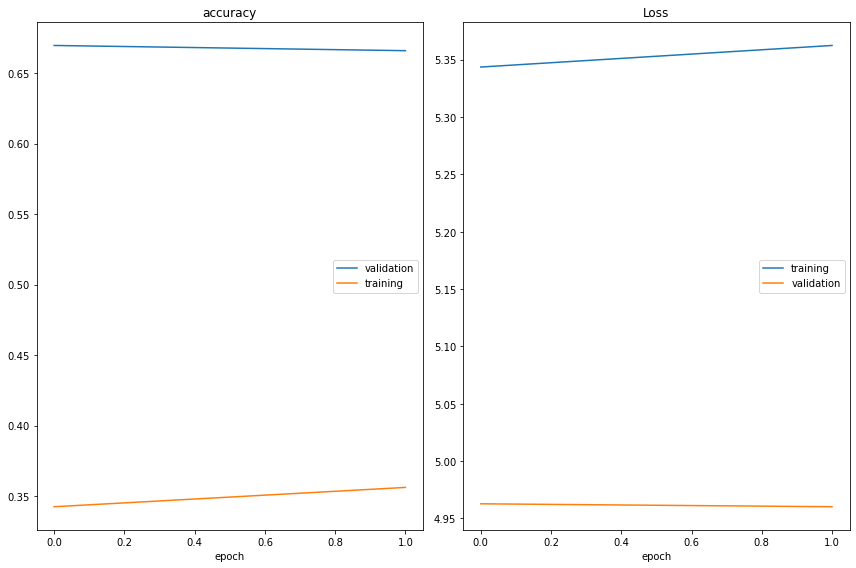

accuracy
	validation       	 (min:    0.666, max:    0.670, cur:    0.666)
	training         	 (min:    0.342, max:    0.356, cur:    0.356)
Loss
	training         	 (min:    5.344, max:    5.362, cur:    5.362)
	validation       	 (min:    4.960, max:    4.963, cur:    4.960)
E: 1, Ing: 0.666, Class: 0.356, L: 4.96


KeyboardInterrupt: 

In [40]:
solver.training_jointly(Train_Dataloader, Val_Dataloader, 20, display_every = 64)

In [33]:
torch.save(solver.state_dict(), "./Pyra.pth")

In [32]:
# Save Unique Ingredients
torch.save(Unique_Ingredients, "./Ingredients.pth")
torch.save(Unique_Classes, "./Classes.pth")

In [34]:
# Delete all Working Files other than PTH 
!rm -rf Recipes5k